In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [64]:
df = pd.read_csv('data/ds_sal_data.csv')

In [65]:
df.head()

,work_year,job_title,job_category,salary_currency,salary,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,2023,Data DevOps Engineer,Data Engineering,EUR,88000,95012,Germany,Mid-level,Full-time,Hybrid,Germany,L
1,2023,Data Architect,Data Architecture and Modeling,USD,186000,186000,United States,Senior,Full-time,In-person,United States,M
2,2023,Data Architect,Data Architecture and Modeling,USD,81800,81800,United States,Senior,Full-time,In-person,United States,M
3,2023,Data Scientist,Data Science and Research,USD,212000,212000,United States,Senior,Full-time,In-person,United States,M
4,2023,Data Scientist,Data Science and Research,USD,93300,93300,United States,Senior,Full-time,In-person,United States,M


In [66]:
def shorten_category(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

In [67]:
country_map =shorten_category(df.company_location.value_counts() , 60)
df['company_location'] = df['company_location'].map(country_map)
df['company_location'].value_counts()

company_location
United States     8132
United Kingdom     449
Other              363
Canada             226
Spain              113
Germany             72
Name: count, dtype: int64

In [94]:
d_corr = df[['job_title','job_category','employee_residence','experience_level','employment_type','company_location','company_size','salary_in_usd']]

In [95]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
d_corr[['job_title','job_category','employee_residence','experience_level','employment_type','company_location','company_size']] = enc.fit_transform(d_corr[['job_title','job_category','employee_residence','experience_level','employment_type','company_location','company_size']])

C:\Users\salvi\AppData\Local\Temp\ipykernel_24636\827607103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_corr[['job_title','job_category','employee_residence','experience_level','employment_type','company_location','company_size']] = enc.fit_transform(d_corr[['job_title','job_category','employee_residence','experience_level','employment_type','company_location','company_size']])


<Axes: >

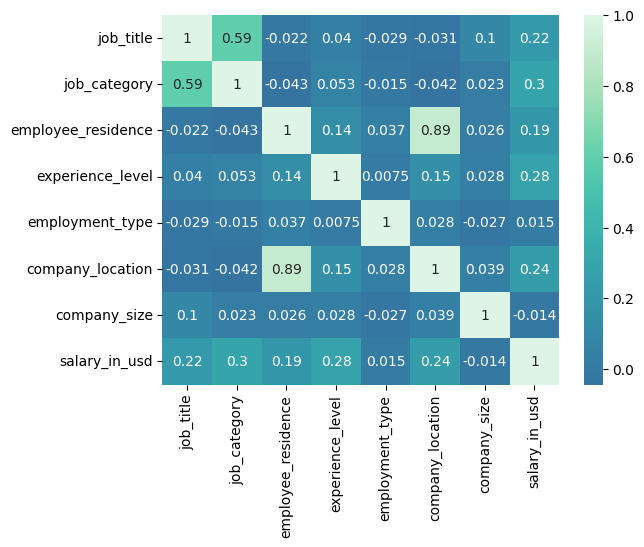

In [100]:
sns.heatmap(d_corr.corr(),cmap='mako',center = 0,annot=True)

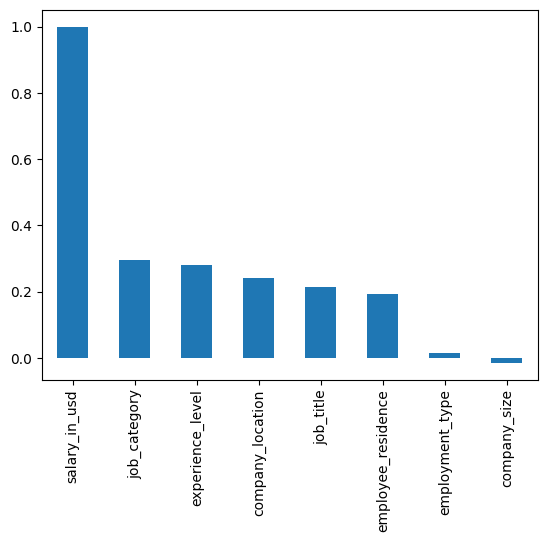

In [98]:
d_corr.corr()['salary_in_usd'].sort_values(ascending=False).plot(kind='bar')
plt.show()

In [68]:
X = df.drop(columns=['salary_in_usd'],axis=1)
X = X[['job_title','job_category','employee_residence','experience_level','employment_type','company_location','company_size']]
Y = df['salary_in_usd']

In [69]:
X

,job_title,job_category,employee_residence,experience_level,employment_type,company_location,company_size
0,Data DevOps Engineer,Data Engineering,Germany,Mid-level,Full-time,Germany,L
1,Data Architect,Data Architecture and Modeling,United States,Senior,Full-time,United States,M
2,Data Architect,Data Architecture and Modeling,United States,Senior,Full-time,United States,M
3,Data Scientist,Data Science and Research,United States,Senior,Full-time,United States,M
4,Data Scientist,Data Science and Research,United States,Senior,Full-time,United States,M
...,...,...,...,...,...,...,...
9350,Data Specialist,Data Management and Strategy,United States,Senior,Full-time,United States,L
9351,Data Scientist,Data Science and Research,United States,Senior,Full-time,United States,L
9352,Principal Data Scientist,Data Science and Research,United States,Mid-level,Full-time,United States,L
9353,Data Scientist,Data Science and Research,United States,Entry-level,Full-time,United States,S


In [70]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [71]:
cat_columns = ['job_title','job_category','employee_residence','experience_level','employment_type','company_location','company_size']

label_transformer = OrdinalEncoder()
preprocessor=ColumnTransformer(
    [
    ("OrdinalEncoder",label_transformer,cat_columns),
    ],remainder='passthrough
)

In [72]:
X = preprocessor.fit_transform(X)

In [90]:
type(X)

numpy.ndarray

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((7484, 7), (1871, 7))

In [74]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [75]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 55916.0902
- Mean Absolute Error: 43505.9922
- R2 Score: 0.2086
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 57036.1051
- Mean Absolute Error: 44118.9868
- R2 Score: 0.2156


Lasso
Model performance for Training set
- Root Mean Squared Error: 55916.0912
- Mean Absolute Error: 43506.0515
- R2 Score: 0.2086
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 57035.2301
- Mean Absolute Error: 44118.7246
- R2 Score: 0.2156


Ridge
Model performance for Training set
- Root Mean Squared Error: 55916.0907
- Mean Absolute Error: 43506.1756
- R2 Score: 0.2086
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 57035.6571
- Mean Absolute Error: 44119.0156
- R2 Score: 0.2156


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 52022.2260
- Mean Absolute Erro

In [81]:
df3 = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)


In [83]:
df3 = df3.reset_index(drop=True)

In [102]:
df3

,Model Name,R2_Score
0,CatBoosting Regressor,0.370374
1,XGBRegressor,0.367026
2,Random Forest Regressor,0.363003
3,Decision Tree,0.338231
4,K-Neighbors Regressor,0.256852
5,Lasso,0.215599
6,Ridge,0.215588
7,Linear Regression,0.215575
8,AdaBoost Regressor,0.131855
